In [1]:
import os
import openai
import numpy as np
import pandas as pd
from tqdm import tqdm
from openai import OpenAI
from pymilvus import Collection, CollectionSchema, FieldSchema, DataType, connections
from pymilvus import connections, utility
from langchain_openai import OpenAIEmbeddings
from langchain import text_splitter 
from langchain_community.vectorstores import Milvus
from langchain_community.retrievers.milvus import MilvusRetriever
from langchain.text_splitter import RecursiveCharacterTextSplitter

from transformers import AutoTokenizer, AutoModel

/Users/yj/.pyenv/versions/myMechanic/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 실험환경

In [2]:
# 임베딩 모델이름
company = 'OPENAI'
embedding_models = 'text-embedding-3-large'
header_include = True
table_include = True
split_yn = False
documnet_name = "2024 IONIQ5"

In [3]:
exp_name = f"{company}_{embedding_models}_h{header_include}_t{table_include}_s{split_yn}"
exp_dir = '../result/' + exp_name

os.makedirs(exp_dir, exist_ok=True)

In [4]:
DOC_DATA_DIR = '../../../pdf_parsing/parse_result/'
DOC_DATA_PATH =  DOC_DATA_DIR + 'doc_ioniq5_result.parquet'
OPENAI_API_KEY = os.environ['OPENAI_API_KEY']

tqdm.pandas()

In [5]:
df = pd.read_parquet(DOC_DATA_PATH)

## 문장 길이

<Axes: ylabel='Frequency'>

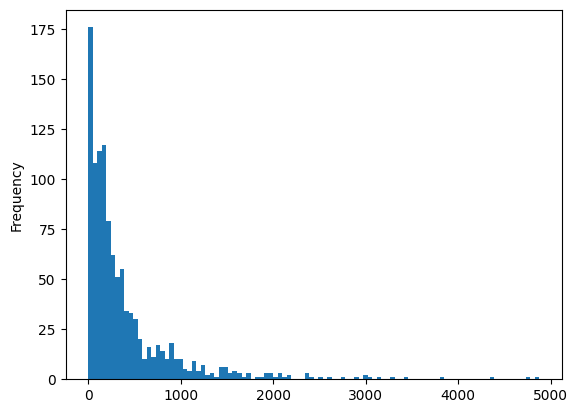

In [11]:
df['doc_table_contents'].apply(lambda x: len(x)).plot.hist(bins=100)

# Embedding

In [6]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [7]:
global tokens

tokens=0


def get_embedding(text):
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text
    )
    global tokens
    tokens = tokens + response.usage.total_tokens
    # print(index)
    return response.data[0].embedding

In [327]:
df['doc_table_contents'] = \
    "설명서 대제목:" + df['h1'] + '\n' + \
    "설명서 중제목:" + df['h2'].fillna('') + '\n' +\
    "설명서 소제목:" + df['h3'].fillna('') + '\n' + \
    df['doc_table_contents']

In [28]:
embedding_result = df['doc_table_contents'].progress_apply(lambda x: get_embedding(x))

100%|██████████| 1089/1089 [08:49<00:00,  2.06it/s]


In [31]:
print(f"TOKEN USAGE: {tokens}")
print(f"PRICE USAGE: {(tokens/1024/1024)*0.02*1300}원")

TOKEN USAGE: 458270
PRICE USAGE: 11.363048553466797원


In [32]:
df['embeddings'] = embedding_result

## Embedding 결과 저장

In [34]:
embedding_result_path = exp_dir + '/embeddings.parquet'
df.to_parquet(embedding_result_path, index=False)

# Vector DB 저장

In [130]:
MILVUS_HOST = os.environ['MILVUS_HOST']
MILVUS_PORT = os.environ['MILVUS_PORT']
COLLECTION_NAME = "ioniq5_2024_manual"
connections.connect(alias="default", host=MILVUS_HOST, port=MILVUS_PORT)

In [326]:
embedding_result_path = exp_dir + '/embeddings.parquet'
df = pd.read_parquet(embedding_result_path)

## Document 내 header 제외

**내용이 없기 때문**

In [15]:
df = df[df['h1']!=df['doc_contents']]
df = df[df['h2']!=df['doc_contents']]
df = df[df['h3']!=df['doc_contents']]

In [16]:
df['car_type'] = documnet_name

**Collection 삭제 예시**

In [9]:
# utility.drop_collection("ioniq5_2024_manual")

## Collection 생성

In [131]:
id_field = FieldSchema(name="id", dtype=DataType.INT64, is_primary=True, auto_id=False)
car_type_filed = FieldSchema(name="car_type", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='차종')
major_h_filed = FieldSchema(name="majorheading", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='설명서의 대제목')
sub_h_filed = FieldSchema(name="subheadings", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                         description='설명서의 중제목')
minor_h_filed = FieldSchema(name="minorheading", dtype=DataType.VARCHAR, max_length=100, is_primary=False, auto_id=False,
                           description='설명서의 소제목')
contents_filed = FieldSchema(name="contents", dtype=DataType.VARCHAR, max_length=20000, is_primary=False, auto_id=False,
                            description='설명서의 내용')
imgurl_filed = FieldSchema(name="img_url", dtype=DataType.ARRAY, element_type=DataType.VARCHAR, max_capacity=20, max_length=50,
                            description='이미지 URL 경로')
tblimgurl_field = FieldSchema(name="tbl_img_url", dtype=DataType.ARRAY, element_type=DataType.VARCHAR, max_capacity=20, max_length=50,
                            description='표 이미지 URL 경로')
tbl_contents_filed = FieldSchema(name="tbl_contents", dtype=DataType.VARCHAR, max_length=10000, is_primary=False, auto_id=False,
                            description='표 내용')
page_filed = FieldSchema(name="block_nums", dtype=DataType.VARCHAR, max_length=7, is_primary=False, auto_id=False,
                            description='page번호')
vector_filed = FieldSchema(name="vector", dtype=DataType.FLOAT_VECTOR, dim=3072)
# 컬렉션 스키마 정의
schema = CollectionSchema(
    fields=[
        id_field, 
        car_type_filed,
        major_h_filed,
        sub_h_filed,
        minor_h_filed,
        contents_filed,
        imgurl_filed,
        tblimgurl_field,
        tbl_contents_filed,
        page_filed,
        vector_filed],
    description="2024 아이오닉5 문서"
)

# 컬렉션 생성
if COLLECTION_NAME not in utility.list_collections():
    collection = Collection(name=COLLECTION_NAME, schema=schema)
else:
    collection = Collection(name=COLLECTION_NAME)


## Data 적재

In [13]:
#Index 생성
df = df.reset_index(drop=True).reset_index()

#NaN 처리
df[['table_contents']] = df[['table_contents']].fillna('')
df['img_urls'] = df['img_urls'].apply(lambda d: d.tolist() if d is not None else [])
df['table_img_urls'] = df['table_img_urls'].apply(lambda d: d.tolist() if d is not None else [])

# Pandas DataFrame에서 데이터 추출 및 Milvus에 삽입
ids = df['level_0'].to_list()
car_types = df['car_type'].to_list()
h1s = df['h1'].to_list()
h2s = df['h2'].fillna('').astype(str).to_list()
h3s = df['h3'].fillna('').astype(str).to_list()
cons = df['doc_table_contents'].to_list()
img_urls = df['img_urls'].to_list()
table_img_urls = df['table_img_urls'].to_list()
table_contents = df['table_contents'].to_list()
blocks = df['block_num'].to_list()
vectors = df['embeddings'].to_list()

In [ ]:
if COLLECTION_NAME not in utility.list_collections():
    mr = collection.insert([ids, car_types, h1s, h2s, h3s, cons, img_urls, table_img_urls, table_contents, blocks, vectors])

## Index 생성

In [ ]:
collection.create_index(
    field_name="vector", 
    index_params={
        "index_type": "IVF_FLAT", 
        "metric_type": "COSINE", 
        "params": {"nlist": df['h2'].nunique()} # Cluster 개수
        }
)

# Evaluation

## 평가 데이터 불러오기

In [8]:
df = pd.read_parquet("/Users/yj/Kim/3.study/5.GenAI/my-small-mechanic/embeddings/evaluation_dataset/llm_qa_testset_gpt35_turbo.parquet")

In [132]:
client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [133]:
topK = 5
nprobe = int(df.groupby('h2').size().max())
SEARCH_PARAM = {
    "index_type": "IVF_FLAT", "metric_type": "COSINE", "params": {"nprobe": nprobe}
}

def get_embedding(text):
    response = client.embeddings.create(
        model="text-embedding-3-large",
        input=text
    )
    return response.data[0].embedding

def embed_search(search_string):
    search_embeddings = get_embedding(search_string)#['vectors'][0].tolist()
    return search_embeddings


def search_doc(query, topK=3):
    user_vector = embed_search(query)
    results = collection.search([user_vector],"vector",param=SEARCH_PARAM, limit=topK, expr=None, 
                             output_fields=['majorheading', 'subheadings', 'minorheading', 'contents', 'img_url', 'tbl_img_url', 'tbl_contents', 'block_nums'])

    search_dict = {}
    
    for i, result in enumerate(results[0]):
        doc_entity = result.entity
        doc = {
            'distance': result.distance,
            'majorheading': doc_entity.get('majorheading'),
            'subheadings': doc_entity.get('subheadings'),
            'minorheading': doc_entity.get('minorheading'),
            'contents': doc_entity.get('contents'),
            'img_url': doc_entity.get('img_url'),
            'tbl_img_url': doc_entity.get('tbl_img_url'),
            'tbl_contents': doc_entity.get('tbl_contents'),
            'block_nums': doc_entity.get('block_nums'),
            
        }
        search_dict[i] = doc
    return search_dict

## 평가

In [43]:
qaset = df[['block_num', 'doc_contents', 'question', 'answer']]
qaset = qaset[(qaset['question']!='error') & (qaset['question']!='')]

In [44]:
qaset['question'] = qaset['question'].apply(lambda x: list(map(lambda y: y[2:], x.split('\n'))))
qaset['answer'] = qaset['answer'].apply(lambda x: list(filter(lambda z: len(z)>0, list(map(lambda y: y[2:], x.split('\n'))))))

In [46]:
block_num_list = []
contents_list = []
question_list = []
answer_list = []
for i, row in qaset.iterrows():
    block_num = row['block_num']
    doc_contents = row['doc_contents']
    question = row['question']
    answer = row['answer']
    
    for q,a in zip(question, answer):
        block_num_list.append(block_num)
        contents_list.append(doc_contents)
        question_list.append(q)
        answer_list.append(a)

In [70]:
qaset = pd.DataFrame({'block_num': block_num_list, 'doc_contents': contents_list, 'question': question_list, 'answer': answer_list})

In [71]:
qaset['doc1'] = np.nan
qaset['doc2'] = np.nan
qaset['doc3'] = np.nan
qaset['doc4'] = np.nan
qaset['doc5'] = np.nan


In [74]:
for i, row in tqdm(qaset.iterrows()):
    query = row['question']
    quert_result = search_doc(query, topK)
    for k, v in quert_result.items():
        columns = f"doc{k+1}"
        qaset.loc[i, columns] = v['block_nums']
        
    if i==100:
        break

100it [00:47,  2.08it/s]


In [75]:
qaset.to_parquet(f'../result/{exp_name}/prediection.parquet', index=False)

In [78]:
sample_qaset = qaset.loc[0:99].copy()

## Top 1 정확도

In [83]:
len(sample_qaset[sample_qaset['block_num']==sample_qaset['doc1']])/len(sample_qaset)

0.52

Top 2 정확도

In [95]:
sample_qaset[['block_num', 'doc1', 'doc2']].apply(lambda x: x[0] in x[1:3].values, axis=1).sum()/100

0.69

Top 3 정확도

In [96]:
sample_qaset[['block_num', 'doc1', 'doc2', 'doc3']].apply(lambda x: x[0] in x[1:4].values, axis=1).sum()/100

0.78

Top 5 정확도

In [97]:
sample_qaset[['block_num', 'doc1', 'doc2', 'doc3', 'doc4','doc5']].apply(lambda x: x[0] in x[1:6].values, axis=1).sum()/100

0.86

# Reranker 적용

In [110]:
import torch
import numpy as np

In [108]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("Dongjin-kr/ko-reranker")
model = AutoModelForSequenceClassification.from_pretrained("Dongjin-kr/ko-reranker")

In [109]:
def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

In [100]:
qaset_rr = pd.DataFrame({'block_num': block_num_list, 'doc_contents': contents_list, 'question': question_list, 'answer': answer_list})

In [229]:
qaset_rr['doc1'] = np.nan
qaset_rr['doc2'] = np.nan
qaset_rr['doc3'] = np.nan
qaset_rr['doc4'] = np.nan
qaset_rr['doc5'] = np.nan

qaset_rr['rr_doc1'] = np.nan
qaset_rr['rr_doc2'] = np.nan
qaset_rr['rr_doc3'] = np.nan
qaset_rr['rr_doc4'] = np.nan
qaset_rr['rr_doc5'] = np.nan


In [265]:
for i, row in tqdm(qaset_rr.iterrows()):
    
    if i>509:
        query = row['question']
        query_result = search_doc(query, topK)
        query_result = OrderedDict(sorted(query_result.items(), key=lambda x: x[0], reverse=False))
        pairs = list(map(lambda k: [k[0],k[1][1]['contents']], zip([query]*len(query_result), query_result.items())))
        block_nums = list(map(lambda x: x[1]['block_nums'], query_result.items()))
        qaset_rr.loc[i, ['doc1', 'doc2', 'doc3', 'doc4', 'doc5']] = np.array(block_nums)
        with torch.no_grad():
            inputs = tokenizer(pairs, padding=True, truncation=True, return_tensors='pt', max_length=512)
            scores = model(**inputs, return_dict=True).logits.view(-1, ).float()
            scores = exp_normalize(scores.numpy())
            
            qaset_rr.loc[i, ['rr_doc1', 'rr_doc2', 'rr_doc3', 'rr_doc4', 'rr_doc5']] = np.array(block_nums)[np.argsort(scores)][::-1]


1103it [28:12,  1.53s/it]


In [ ]:
qaset_rr.to_parquet('test.paruqet', index=False)

In [269]:
sample_qaset_rr = qaset_rr.copy()
sample_datasize = len(sample_qaset_rr)

## Hit Rate

In [270]:
print(len(sample_qaset_rr[sample_qaset_rr['block_num']==sample_qaset_rr['doc1']])/sample_datasize)
print(len(sample_qaset_rr[sample_qaset_rr['block_num']==sample_qaset_rr['rr_doc1']])/sample_datasize)

0.5738893925657298
0.6328195829555757


In [271]:
print(sample_qaset_rr[['block_num', 'doc1', 'doc2']].apply(lambda x: x[0] in x[1:3].values, axis=1).sum()/sample_datasize)
print(sample_qaset_rr[['block_num', 'rr_doc1', 'rr_doc2']].apply(lambda x: x[0] in x[1:3].values, axis=1).sum()/sample_datasize)

0.7189483227561196
0.7479601087941976


In [272]:
print(sample_qaset_rr[['block_num', 'doc1', 'doc2', 'doc3']].apply(lambda x: x[0] in x[1:4].values, axis=1).sum()/sample_datasize)
print(sample_qaset_rr[['block_num', 'rr_doc1', 'rr_doc2', 'rr_doc3']].apply(lambda x: x[0] in x[1:4].values, axis=1).sum()/sample_datasize)

0.7796917497733454
0.8041704442429737


In [273]:
print(sample_qaset_rr[['block_num', 'doc1', 'doc2', 'doc3', 'doc4','doc5']].apply(lambda x: x[0] in x[1:6].values, axis=1).sum()/sample_datasize)
print(sample_qaset_rr[['block_num', 'rr_doc1', 'rr_doc2', 'rr_doc3', 'rr_doc4','rr_doc5']].apply(lambda x: x[0] in x[1:6].values, axis=1).sum()/sample_datasize)

0.8395285584768812
0.8395285584768812


## MRR

In [314]:
def get_mrr(x):
    x = x.values
    rank = np.where(x[1:6]==x[0])[0]
    if len(rank)>0:
        return 1/(rank[0] + 1)
    else:
        return 0

In [318]:
sample_qaset_rr['mrr'] = sample_qaset_rr[['block_num', 'doc1', 'doc2', 'doc3', 'doc4','doc5']]\
        .apply(lambda x: get_mrr(x), axis=1)

sample_qaset_rr['rr_mrr'] = sample_qaset_rr[['block_num', 'rr_doc1', 'rr_doc2', 'rr_doc3', 'rr_doc4','rr_doc5']]\
        .apply(lambda x: get_mrr(x), axis=1)

In [319]:
sample_qaset_rr['mrr'].mean()

0.6804472650347537

In [320]:
sample_qaset_rr['rr_mrr'].mean()

0.7171501964339679

In [345]:
df[~df['table_img_urls'].isna()][['block_num', 'h1','h2', 'h3', 'doc_table_contents', 'table_contents', 'img_urls', 'embeddings']].head()

,block_num,h1,h2,h3,doc_table_contents,table_contents,img_urls,embeddings
28,21_3,전기차 시작하기,전기 자동차 충전 종류,충전 시간에 대한 정보,설명서 대제목:전기차 시작하기\n설명서 중제목:전기 자동차 충전 종류\n설명서 소제...,표: 21_4\n| | 충전 방법 | 충전 방법 | 기본형 ...,None,"[0.0017971007619053125, -0.034057457000017166,..."
29,22_0,전기차 시작하기,전기 자동차 충전 종류,전기 자동차 충전 종류,설명서 대제목:전기차 시작하기\n설명서 중제목:전기 자동차 충전 종류\n설명서 소제...,표: 22_2\n| | 구 분 | 완속 충전 ...,None,"[0.028417671099305153, -0.015612320974469185, ..."
32,23_3,전기차 시작하기,전기 자동차 충전 표시등,충전 상태 표시등,설명서 대제목:전기차 시작하기\n설명서 중제목:전기 자동차 충전 표시등\n설명서 소...,표: 23_6\n| | 충전 표시등 동작 | 충전량[%] |\n|---...,[./image/ioniq5_2024/23_4_img.png],"[-0.0076967403292655945, -0.013680819422006607..."
33,23_15,전기차 시작하기,전기 자동차 충전 표시등,충전 상태 표시등,설명서 대제목:전기차 시작하기\n설명서 중제목:전기 자동차 충전 표시등\n설명서 소...,표: 23_18\n| | 충전 표시등 동작 | 충전량[%] |\n|--...,[./image/ioniq5_2024/23_16_img.jpeg],"[0.010524286888539791, -0.011710510589182377, ..."
36,24_7,전기차 시작하기,충전 커넥터 잠금,완속 충전 시 충전 커넥터 잠금 모드,설명서 대제목:전기차 시작하기\n설명서 중제목:충전 커넥터 잠금\n설명서 소제목:완...,표: 24_8\n| | 커넥터 잠금 | 동작 | 동작 | 동...,None,"[0.001777324010618031, 0.004161614924669266, -..."


In [336]:
print(df[~df['table_contents'].isna()]['doc_contents'].reset_index(drop=True).loc[1])

전기 자동차 충전 종류
충전 방법의 종류
 충전기의 형상 및 사용 방법은 각 충전기 제조사마다 다를 수 있습니다.구동용(고전압) 배터리 상태와 수명, 충전기의 사양, 주변 온도에 따라 배터리를 충전하는 시간이 달라질 수 있습니다.


In [342]:
print(df['doc_table_contents'].loc[3])

설명서 대제목:전기차 시작하기
설명서 중제목:전기 자동차 개요
설명서 소제목:배터리에 대한 정보
설명서 대제목:전기차 시작하기
설명서 중제목:전기 자동차 개요
설명서 소제목:배터리에 대한 정보
배터리에 대한 정보
 본 차량의 배터리는 모터 및 에어컨을 작동시키는 구동용(고전압) 배터리와 조명, 와이퍼, 오디오 등을 작동시키는 보조 배터리(12V)로 구성되어 있습니다. 보조 배터리는 주행 가능 표시등()이켜진 상태 또는 구동용(고전압) 배터리가 충전되는 경우에 자동으로 충전됩니다.


In [ ]:
embedding_result_path = exp_dir + '/embeddings.parquet'
df.to_parquet(embedding_result_path, index=False)